In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from sklearn.datasets import make_regression
from scipy.optimize import leastsq
from scipy import linalg
from scipy.linalg import eigh as largest_eigh
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
np.random.seed(0)

In [2]:
def simulate_data(gamma,point=100,bias = 1,noise = 1,n_informative = 10,random_state=1):
    n_features = int(gamma* point)
    n_samples = int(1/gamma * point)
    x, y, coef = make_regression(n_samples = n_samples, n_features = n_features,
                                n_informative =n_informative, n_targets = 1,bias = bias,
                                noise = noise, coef = True,random_state=random_state)
    u, s, vh = np.linalg.svd(x, full_matrices=False)
    xa = u @ np.diag(s) @ vh
    return xa, y, coef
    
def least_square(x,y):
    coefs = np.linalg.inv(x.T @ x) @ x.T @ y
    return coefs

def inverse_least_square(x,y):
    coefs = x.T @ np.linalg.inv(x @ x.T)  @ y
    return coefs

def mse(y_true, y_pred):
    return np.average((y_true - y_pred) ** 2)

def obj(beta, x, y):
    error = mse(y,np.matmul(x,beta))
    return error

<h1> Question 1</h1>

In [47]:
gammas = [5,0.1]
simulations = 3
mse_ls= []; mse_ils= []; df_ls =[]; df_ils = [];df_ls_test =[]; df_ils_test = []
for gamma in gammas:
    for n in range(simulations):
        x, y, _ = simulate_data(gamma,point=1000,random_state=n)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        coefs_ls = least_square(X_train,y_train)
        coefs_ils = inverse_least_square(X_train,y_train)
        mse_ls.append(mse(X_test @ coefs_ls, y_test))
        df_ls.append(np.sum(np.cov(X_train @ coefs_ls,y_train))/
                     np.std(y_train - X_train @ coefs_ls)**2)
        df_ils.append(np.sum(np.cov(X_train @ coefs_ils,y_train))/
                      np.std(y_train - X_train @ coefs_ils)**2)
        df_ls_test.append(np.sum(np.cov(X_test @ coefs_ls,y_test))/
                          np.std(y_test - X_test @ coefs_ls)**2)
        df_ils_test.append(np.sum(np.cov(X_test @ coefs_ils,y_test))/
                           np.std(y_test - X_test @ coefs_ils)**2)
        mse_ils.append(mse(X_test @ coefs_ils, y_test)) 
    if gamma == gammas[0]:
        data = pd.DataFrame({'df_ls_test':df_ls_test,'df_ils_test':df_ils_test,'df_ls':df_ls,'df_ils':df_ils,'mse_ls':mse_ls,'mse_ils':mse_ils,'type': ['n<p'] * simulations})
        mse_ls= []; mse_ils= []; df_ls =[]; df_ils = []
    else:
        for i in range(simulations):
            data= data.append({'df_ls_test':df_ls_test[i],'df_ils_test':df_ils_test[i],'df_ls':df_ls[i],'df_ils':df_ils[i],'mse_ls':mse_ls[i],'mse_ils':mse_ils[i],'type': 'n > p'},ignore_index=True)
data.groupby(['type'])[['mse_ls','mse_ils']].mean()

,mse_ls,mse_ils
type,,
n > p,2.019759e+00,2.356262e+09
n<p,8.214115e+12,3.122049e+04


In [52]:
# Degree of freedom
data.groupby(['type'])[['df_ls','df_ils','df_ls_test','df_ils_test']].mean()

,df_ls,df_ils,df_ls_test,df_ils_test
type,,,,
n > p,142253.238478,1.001166e+00,1.015386,1.125285
n<p,1.012686,2.706456e+31,1.015386,1.125285


$ \hat{B}  = \text{arg min}{ ||b||^2 : \text{b minimizes } \frac{1}{2n}||y - XB||_2^2} $
J(w) is called the least square cost function. 
In the case $N > P$:
\begin{align}
\triangledown J = X^TXB-X^Ty = 0
\end{align}
Hence,
\begin{align}
X^TXB=X^Ty \\
B=(X^TX)^{-1} X^Ty
\end{align}

We need to find the pseudo inverse which is computationally expensive for big datasets. Hence, we suggest alternatives in this homework (gradient descent).

In the case $N < P$, by applying Lagrangian theory:
$L(B, \lambda) = ||B||^2 + \lambda^T(XB − y)$ where $\lambda^T = (\lambda_1, \lambda_2, . . . \lambda_N ). \lambda_i, i = 1, 2, . . . N$ are the lagrangian parameters. Taking the derivatives with respect to $B$ and $\lambda$:
\begin{align}
2B + X^T \lambda = 0 \\
B = -\frac{X^T\lambda}{2}\\ 
\text{and}\\
XB - y = 0\\
\frac{- XX^T\lambda}{2} = y\\
\text{Therefore}\\
\lambda = - (XX^T)^{-1}2y\\
\text{Hence}\\
B= X^T (XX^T)^{-1}y\\
\end{align}


The degree of freedom based on Stein's Lemma is given in the code above.



<h1>Question 2

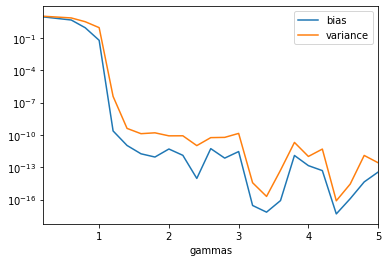

In [60]:
def run_lm():
    bias = []; variance = []
    gammas = np.linspace(0.2,5,25)
    for gamma in gammas:
        x, y, _ = simulate_data(gamma,point=100,bias=3,noise=1)
        #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        beta_init = np.array([1]* x.shape[1])
        beta = minimize(obj, beta_init, args=(x,y),method='BFGS', options={'maxiter': 50}).x
        y_pred = x @ beta 
        bias.append(np.mean(y - y_pred)** 2)
        variance.append(np.mean((y - y_pred) ** 2))
    return pd.DataFrame({'gammas':gammas,'bias':bias, 'variance':variance})

data = run_lm()
data.plot(x='gammas',y=['bias','variance'],logy=True)

<h1> Question 3

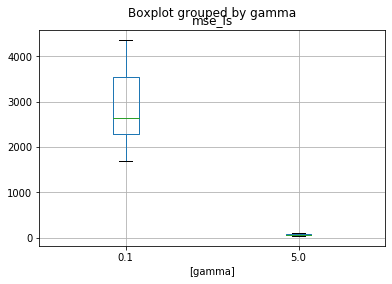

In [7]:
gammas = [5,0.1]
epochs = 50; simulations = 20
mse_ls= []
for gamma in gammas:
    for n in range(simulations):
        x, y, beta_real = simulate_data(gamma=gamma,point=100,random_state=n)
        #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        beta_init = np.array([0]*x.shape[1])
        eigenValues = linalg.eig(x @ x.T)[0]
        eigenValues.sort()
        eigen_max = eigenValues[-1]
        for i in range(epochs): 
            beta = beta_init + 1/eigen_max.real *  (x.T / x.shape[0]) @ (y - x @ beta_init)
            beta_init = beta
        mse_ls.append(mse(beta_real,beta))
    if gamma == gammas[0]:
        data = pd.DataFrame({'mse_ls':mse_ls,'gamma': [gamma] * simulations})
        mse_ls= []
    else:
        for i in range(simulations):
            data= data.append({'mse_ls':mse_ls[i],'gamma': gamma},ignore_index=True)

data.boxplot(by='gamma')

Hence, the method converges only when gamma is large, that is the case $N < P$

<h1>Question 4

True Beta 86.50810998606796  Pred Beta 86.54100839928071


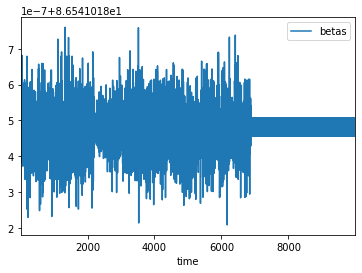

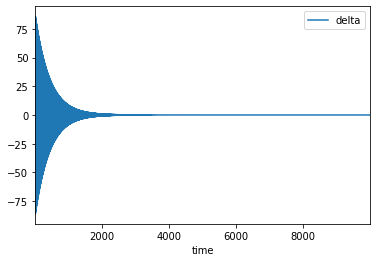

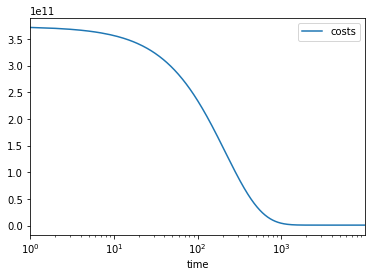

In [111]:
def cost(beta,x,y):
    return (1/ 2*len(y)) * np.sum(np.square(y- (x @ np.array(beta))))

epochs = 10000
data = pd.DataFrame()
x, y, beta_real = simulate_data(gamma=0.01,bias=5,noise=1,n_informative=1)
whi = np.where(beta_real!=0)[0][0]
beta_init = [0] * x.shape[1]
for i in range(epochs):
    beta = minimize(cost, beta_init, args=(x, y),method='BFGS', options={'maxiter': 50}).x
    delta = (x.T / x.shape[0]) @ (y - x @ beta_init)
    beta_init = beta + delta
    c = cost(beta_init,x,y)
    data = data.append({'time':i,'betas': beta[whi],'delta':delta[whi],'costs':c},ignore_index=True)

print('True Beta', beta_real,' Pred Beta', beta_init[whi])
data.iloc[1:,:].plot(x='time',y='betas')
data.iloc[1:,:].plot(x='time',y='delta')
data.iloc[1:,:].plot(x='time',y='costs',logx=True)

<h1> Question 5

In [128]:
x, y, beta_real = simulate_data(gamma=0.01,bias=5,noise=5,n_informative=1)
alg = Pipeline([('scaler',StandardScaler()), ('reg',Ridge())])
parameters = {
                'reg__alpha': np.logspace(-100, 1, num=50,base=2)
                }
clf = GridSearchCV(alg,
                   parameters,
                   verbose=0, 
                   scoring="neg_mean_squared_error",
                   cv=10,
                   n_jobs=-1)
clf.fit(x,y)
model = clf.best_estimator_.named_steps["reg"]
print('Best Alpha: ', model.alpha)

Best Alpha:  0.11482836925880943


True Beta 86.50810998606796 beta Hat 86.47574728146213 Beta Gradient 86.49823586734048


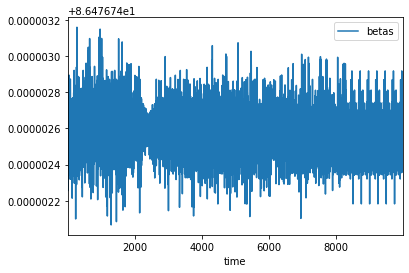

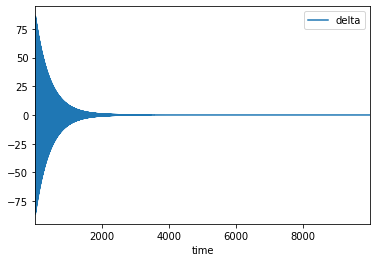

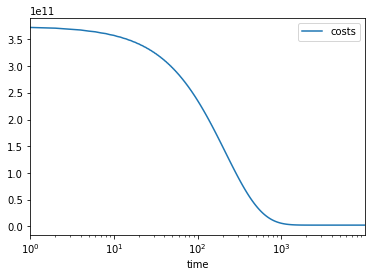

In [142]:
def cost_ridge(beta,x,y,lam):
    return (1/ 2*len(y)) * np.sum(np.square(y- (x @ np.array(beta)))) + (lamda / (2*len(y))) * np.sum(np.square(beta))

epochs = 10000
lam = model.alpha
data = pd.DataFrame()
whi = np.where(beta_real!=0)[0][0]
beta_init = [0] * x.shape[1]
A = x.T @ x
beta_hat = np.linalg.inv(A + lam * np.eye(A.shape[0])) @ (x.T @ y)
for i in range(epochs):
    beta = minimize(cost, beta_init, args=(x, y),method='BFGS', options={'maxiter': 50}).x
    delta = (x.T / x.shape[0]) @ (y - x @ beta_init) + (lam / (2*x.shape[0])) * np.sum(np.square(beta))
    beta_init = beta + delta
    c = cost(beta_init,x,y)
    data = data.append({'time':i,'betas': beta[whi],'delta':delta[whi],'costs':c},ignore_index=True)

print('True Beta', beta_real,'beta Hat', beta_hat[0],'Beta Gradient', beta_init[whi])
data.iloc[1:,:].plot(x='time',y='betas')
data.iloc[1:,:].plot(x='time',y='delta')
data.iloc[1:,:].plot(x='time',y='costs',logx=True)

<h1> Problem 2

<h1>Question 2

In [125]:
all_cost = pd.DataFrame()
def cost(mu, mu_oracle,name,n):
    global all_cost
    cost = np.mean(np.square(mu - mu_oracle))
    data= {'name':name,'cost':cost,'n':n}
    all_cost = all_cost.append(data,ignore_index=True)
    
N  = np.logspace(1,5,5,base=10)
cov_real = np.array([[1, 2], [2, 3]])
mean = np.array([0, 0])

simulations = 100
for n in N:
    n = int(n)
    for i in range(simulations):
        oracle = np.random.multivariate_normal(mean, cov_real, n)
        za = np.random.normal(oracle[:,0], 1, n)
        zb = np.random.normal(oracle[:,1], 1, n)

        # MLE
        z = np.column_stack((za, zb))
        z_means = np.mean(z,axis=0)
        z -= z_means
        cov = np.array([[z[:,0] @ z[:,0], z[:,0] @ z[:,1]], [ z[:,0] @ z[:,1],  z[:,1] @ z[:,1]]])
        coef = np.linalg.inv(np.linalg.inv(cov) + np.eye(2))
        mu_mle = coef @ z.T
        cost(mu_mle[0],oracle[:, 0],'mle_A',n)
        cost(mu_mle[1],oracle[:, 1],'mle_B',n)

        # James Stein
        mu_jes_A = (1 - (n - 2)/ (za@za))*za
        mu_jes_B = (1 - (n - 2)/(zb@zb))*zb
        cost(mu_jes_A,oracle[:, 0],'jes_A',n)
        cost(mu_jes_B,oracle[:, 1],'jes_B',n)

all_cost.pivot_table(values='cost', index= ['n'],columns=['name'], aggfunc=[np.mean,np.std])

mean                                     std            \
name         jes_A     jes_B     mle_A     mle_B     jes_A     jes_B   
n                                                                      
10.0      0.670446  0.744304  0.898764  1.073206  0.342980  0.325369   
100.0     0.577758  0.755471  0.999681  1.014085  0.083529  0.110294   
1000.0    0.570738  0.756627  0.993561  1.005191  0.026432  0.036207   
10000.0   0.572940  0.759628  0.999477  1.003108  0.007547  0.009782   
100000.0  0.572507  0.758096  0.999021  1.000210  0.002368  0.003531   

                              
name         mle_A     mle_B  
n                             
10.0      0.454721  0.504538  
100.0     0.139198  0.144366  
1000.0    0.047277  0.048376  
10000.0   0.013727  0.013538  
100000.0  0.003672  0.004587